In [2]:
import json
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report



from sklearn.preprocessing import OneHotEncoder



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Model - Multinomial Naive Bayes

We have chosen to use Multinomial Naive Bayes because of its simplicity and because it has been known to perfrom well with text data with high dimensionality. Multinomial Naive Bayes algorithm attempts to classify text into categories **(intents)** so that the chatbot can identify the intent of the user and narrow down to the most possible range of responses.The algorithm does this by relying on commonality; words are given weight for particular categories based on their frequency of appearance in that category. 

In [1]:
# Converting json into a dataframe

with open('../Final_Intents.json', 'r') as file:
    data = json.load(file)

# Convert the JSON data into a DataFrame, ignoring missing keys
df = pd.json_normalize(data, 'questions', ['tag', 'responses'], errors='ignore')

# Rename the columns for clarity
df.columns = ['Question', 'Tag', 'Response']



NameError: name 'json' is not defined

In [3]:
df.head()

,Question,Tag,Response
187,Are there hands-on labs and real-world project...,Part-time_Software Engineering,NaN
436,What documents do I need to submit for enrollm...,enrollment_deadline,[Enrollment deadlines vary for each class; for...
296,What does a UX researcher do?,Product_Design_UI/UX_Career_Opportunities,[A UX researcher conducts research with real u...
123,Can you provide information about the enrollme...,Enrollment_Information,"[To enroll in courses at Moringa School, you c..."
625,Is there an emphasis on responsible data repor...,Data_Ethics_and_Privacy,[Data ethics is an integral part of the curric...
268,What is the average salary for roles like SOC ...,Cybersecurity_Career_Opportunities,[Career opportunities include Cybersecurity Co...
461,Is financial aid available for this course?,Data_Science_Course_Duration_and_Fees,[The full-time course lasts for 25 weeks with ...
271,When do applications for the Cybersecurity Cou...,Cybersecurity_Course_Information,[The 18-week Cybersecurity Course covers cyber...


In [4]:
df['Tag'].value_counts()


Data_Science_Career_Opportunities                   15
DevOps_Course_Information                           13
Data_Science_Course_Overview                        12
Data_Science_Project_and_Hands-on_Experience        12
Data_Science_Curriculum_Outline                     12
                                                    ..
Data_Science_Industry_Relevance                      5
Data_Science_Collaborative_Projects_and_Teamwork     5
Ethical_Considerations_in_Data_Science               5
Data_Science_Cybersecurity_Introduction              5
Data_Ethics_and_Privacy                              5
Name: Tag, Length: 75, dtype: int64

In [5]:
df = df.dropna()

This shows a class imbalance because some "tags" appear more frequently than others.  This imbalance will affect the performance of our algorithm;it may struggle to properly learn and make accurate predictions for the minority class, leading to biased results. 

In [9]:
# Text Cleaning
# Remove any unnecessary characters, symbols, or special characters.
# Convert text to lowercase to ensure uniformity.
df['Question'] = df['Question'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)

# Tokenization
#  Split the text into individual words or tokens.
df['Question'] = df['Question'].apply(word_tokenize)


# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['Question'] = df['Question'].apply(lambda x: [word for word in x if word not in stop_words])


# Lemmatization
# Reduce words to their root form to handle different variations.
lemmatizer = WordNetLemmatizer()
df['Question'] = df['Question'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


#Joining tokens
# Combine the list of tokens back into a string 
df['Question'] = df['Question'].apply(lambda x: ' '.join(x))

# ### Feature extraction
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Question'])
X_tfidf

# # One-Hot Encoding 'tag'
# encoder = OneHotEncoder(sparse=False)
# y_one_hot = encoder.fit_transform(df['Tag'])


<612x703 sparse matrix of type '<class 'numpy.float64'>'
	with 3591 stored elements in Compressed Sparse Row format>

In [10]:
from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tfidf, df['Tag'])


# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, 
                                                    random_state=42)



# instantiate
model = MultinomialNB()
model.fit(X_train, y_train)


#Model evaluation


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred,zero_division=1))


Accuracy: 0.65
                                                         precision    recall  f1-score   support

                           Advanced_Data_Science_Topics       0.57      1.00      0.73         4
                                                Contact       1.00      0.33      0.50         3
                     Cybersecurity_Career_Opportunities       0.50      1.00      0.67         1
                           Cybersecurity_Certifications       0.29      1.00      0.44         2
                       Cybersecurity_Course_Information       1.00      0.50      0.67         2
                                Data_Ethics_and_Privacy       1.00      0.57      0.73         7
            Data_Science_Admission_Eligibility_Criteria       1.00      1.00      1.00         3
                       Data_Science_Application_Process       1.00      1.00      1.00         5
                  Data_Science_Applications_in_Business       0.75      1.00      0.86         3
              

In [11]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(MultinomialNB(), X_tfidf, df['Tag'], cv=5)
print(f"Cross-validated Accuracy: {scores.mean():.2f}")


Cross-validated Accuracy: 0.39


In [13]:
# Evaluate the model on the test set
accuracy = model.score(X_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

ValueError: Found input variables with inconsistent numbers of samples: [213, 612]

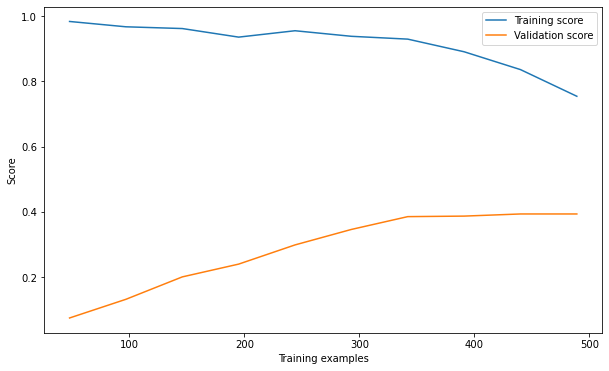

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(), X_tfidf, df['Tag'], cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


 model is likely experiencing overfitting. the high training score at the beginning indicates that  model is able to learn and memorize the patterns present in the training data. It suggests that the model is initially capable of fitting the training data well.The decreasing training score as more data is added may indicate that the model is becoming too complex and is fitting the noise in the data rather than the underlying patterns. The model is essentially memorizing the training set rather than learning to generalize.The plateau in the validation score indicates that, after a certain point, adding more data doesn't lead to a significant improvement in the model's ability to generalize to unseen data.

# Using cross validation for hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import make_scorer, accuracy_score, classification_report


# Define the range of alpha values to search
param_grid = {'alpha': [0.1, 1.0, 10.0]}

# Create the model and perform Grid Search
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=7)
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and the best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

In [ ]:
#  retrain
# instantiate
model = MultinomialNB(alpha=0.1)
model.fit(X_train, y_train)


#Model evaluation


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred,zero_division=1))


In [ ]:

train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(alpha=0.1), X_tfidf, df['Tag'], cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


useful in many text analytics applications where sequences of words are relevant. you are essentially generating n-copies of everything.
You could choose other smoothing techniques as well, but the important aspect is that Multinomial Naive Bayes treats each word of the document as a feature assuming the document is composed of unigrams whose probabilities are NOT dependent. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Text Cleaning
# Remove any unnecessary characters, symbols, or special characters.
# Convert text to lowercase to ensure uniformity.
df['Question'] = df['Question'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)

# Tokenization
# Split the text into individual words or tokens.
df['Question'] = df['Question'].apply(word_tokenize)

# N-gram Vectorization
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2))
df['Question_ngrams'] = df['Question'].apply(lambda x: ' '.join(x))
X_ngrams = ngram_vectorizer.fit_transform(df['Question_ngrams'])

# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['Question'] = df['Question'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
# Reduce words to their root form to handle different variations.
lemmatizer = WordNetLemmatizer()
df['Question'] = df['Question'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Joining tokens
# Combine the list of tokens back into a string
df['Question'] = df['Question'].apply(lambda x: ' '.join(x))

# Feature extraction
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Question'])


In [ ]:
# Concatenate X_ngrams and X_tfidf horizontally
import scipy.sparse as sp
X_combined = sp.hstack([X_ngrams, X_tfidf], format='csr')

# Resample the combined data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_combined, df['Tag'])

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Instantiate the model
model = MultinomialNB()

# Fit the model on the training data
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, zero_division=1))


In [ ]:

# Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(), X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


a type of ensemble learning in which multiple base models are trained independently in parallel on different subsets of the training data.

In [ ]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=10, random_state=42)
model.fit(X_train, y_train)


#Model evaluation


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred,zero_division=1))


In [ ]:

# Plot Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    BaggingClassifier(estimator=MultinomialNB(), n_estimators=10, random_state=42),
    X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve')
plt.show()

# Cross-validated accuracy
cv_accuracy = cross_val_score(BaggingClassifier(estimator=MultinomialNB(), n_estimators=10, random_state=42),
                              X_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross-validated Accuracy:", np.mean(cv_accuracy))


# start here

In [ ]:
import pandas as pd
with open('../Final_Intents.json', 'r') as file:
    intents = json.load(file)
    
intents_dict = {}

questions = []
tags = []
for intent in intents:
    for question in intent["questions"]:
        tags.append(intent["tag"])
        questions.append(question)

intents_dict["questions"] = questions
intents_dict["tags"] = tags


df =  pd.DataFrame(intents_dict, columns=["questions", "tags"])
df

In [ ]:
df['tags'].value_counts()

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
# Text Preprocessing Loop
text_column = ['questions']  

for col in text_column:
    # Text Cleaning
    df[col] = df[col].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)

    # Tokenization
    df[col] = df[col].apply(word_tokenize)

    # Removing Stop Words
    stop_words = set(stopwords.words('english'))
    df[col] = df[col].apply(lambda x: [word for word in x if word not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    df[col] = df[col].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    #Joining tokens
    # Combine the list of tokens back into a string 
#     df[col] = df[col].apply(lambda x: ' '.join(x))

In [ ]:
df